In [19]:
#general
import io

# data
import numpy as np
import pandas as pd

# machine learning
import keras

# data visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [21]:
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBRegressor

In [22]:
dataset_DiagnRatios = pd.read_csv("C:/Users/yuliya/Documents/scientific_research/DiagnRatios.csv")
dataset_EmisionLines = pd.read_csv("C:/Users/yuliya/Documents/scientific_research/EmissionLines.csv")
dataset_OutPar = pd.read_csv("C:/Users/yuliya/Documents/scientific_research/OutPar.csv")
dataset_rion_rout = pd.read_csv("C:/Users/yuliya/Documents/scientific_research/rion_rout.csv")

In [23]:
merged_df_EmDiag = pd.merge(dataset_EmisionLines, dataset_DiagnRatios, on='id', how='inner')  # Inner join

In [24]:
num_rows_without_na = dataset_EmisionLines.dropna().shape
print(num_rows_without_na)

(0, 25)


In [25]:
for col in dataset_EmisionLines.columns:
    print(f"Column '{col}' has {dataset_EmisionLines[col].isna().sum()} missing values")

Column 'id' has 0 missing values
Column 'he_1_3889a' has 648325 missing values
Column 'he_1_4026a' has 50015 missing values
Column 'he_1_4471a' has 40209 missing values
Column 'he_1_5876a' has 41457 missing values
Column 'n_2_6584a' has 644613 missing values
Column 'he_1_6678a' has 41457 missing values
Column 'he_1_7065a' has 41459 missing values
Column 'he_2_4686a' has 40927 missing values
Column 'o_1_6300a' has 290145 missing values
Column 'o_1_6363a' has 644613 missing values
Column 'o_3_4959a' has 258971 missing values
Column 'o_3_5007a' has 263867 missing values
Column 's_3_6312a' has 341937 missing values
Column 's_ii_4070a' has 644613 missing values
Column 's_ii_6716a' has 347984 missing values
Column 's_ii_6731a' has 347984 missing values
Column 'ne_3_3869a' has 364939 missing values
Column 'ar_3_7135a' has 365209 missing values
Column 'fe_3_4658a' has 644613 missing values
Column 'fe_3_4659a' has 373954 missing values
Column 'fe_3_5270a' has 644613 missing values
Column 'totl_

In [26]:
num_rows = merged_df_EmDiag.iloc[:, 1:].isna().all(axis=1).sum()

print(f"Number of rows with NaN in all columns except the first: {num_rows}")

Number of rows with NaN in all columns except the first: 34165


In [27]:
#merged_df_EmDiag_filled = merged_df_EmDiag.fillna(merged_df_EmDiag.mean())
#print(merged_df_EmDiag_filled.info)

In [28]:
new_out = dataset_OutPar.iloc[:, :2]
new_df_no_na = new_out.dropna()
print(new_df_no_na.shape)

(585120, 2)


In [29]:
input_to_model = pd.merge(merged_df_EmDiag, new_df_no_na, on='id', how='inner')

# Extract features (X) and target (Y)
X = input_to_model.iloc[:, 1:-1]  # All columns except first (id) and last (Y)
y = input_to_model.iloc[:, -1]    # Last column as target variable

# Split data into training and test sets (80%-20% split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [31]:
params = {
    'objective': 'reg:squarederror',  # 'binary:logistic' for classification
    'eval_metric': 'rmse',  # Use 'logloss' for classification
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 100,
    'subsample': 0.8,  # Helps prevent overfitting
    'colsample_bytree': 0.8,  # Helps prevent overfitting
}


In [32]:
xgb_model = XGBRegressor(**params)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
y_pred = xgb_model.predict(X_test)

In [ ]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
nrmse = rmse / (np.max(y_test) - np.min(y_test))  # Normalized RMSE

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Normalized RMSE: {nrmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error (MSE): 0.03
Root Mean Squared Error (RMSE): 0.17
Normalized RMSE: 0.0339
Mean Absolute Error (MAE): 0.09
R² Score: 0.87


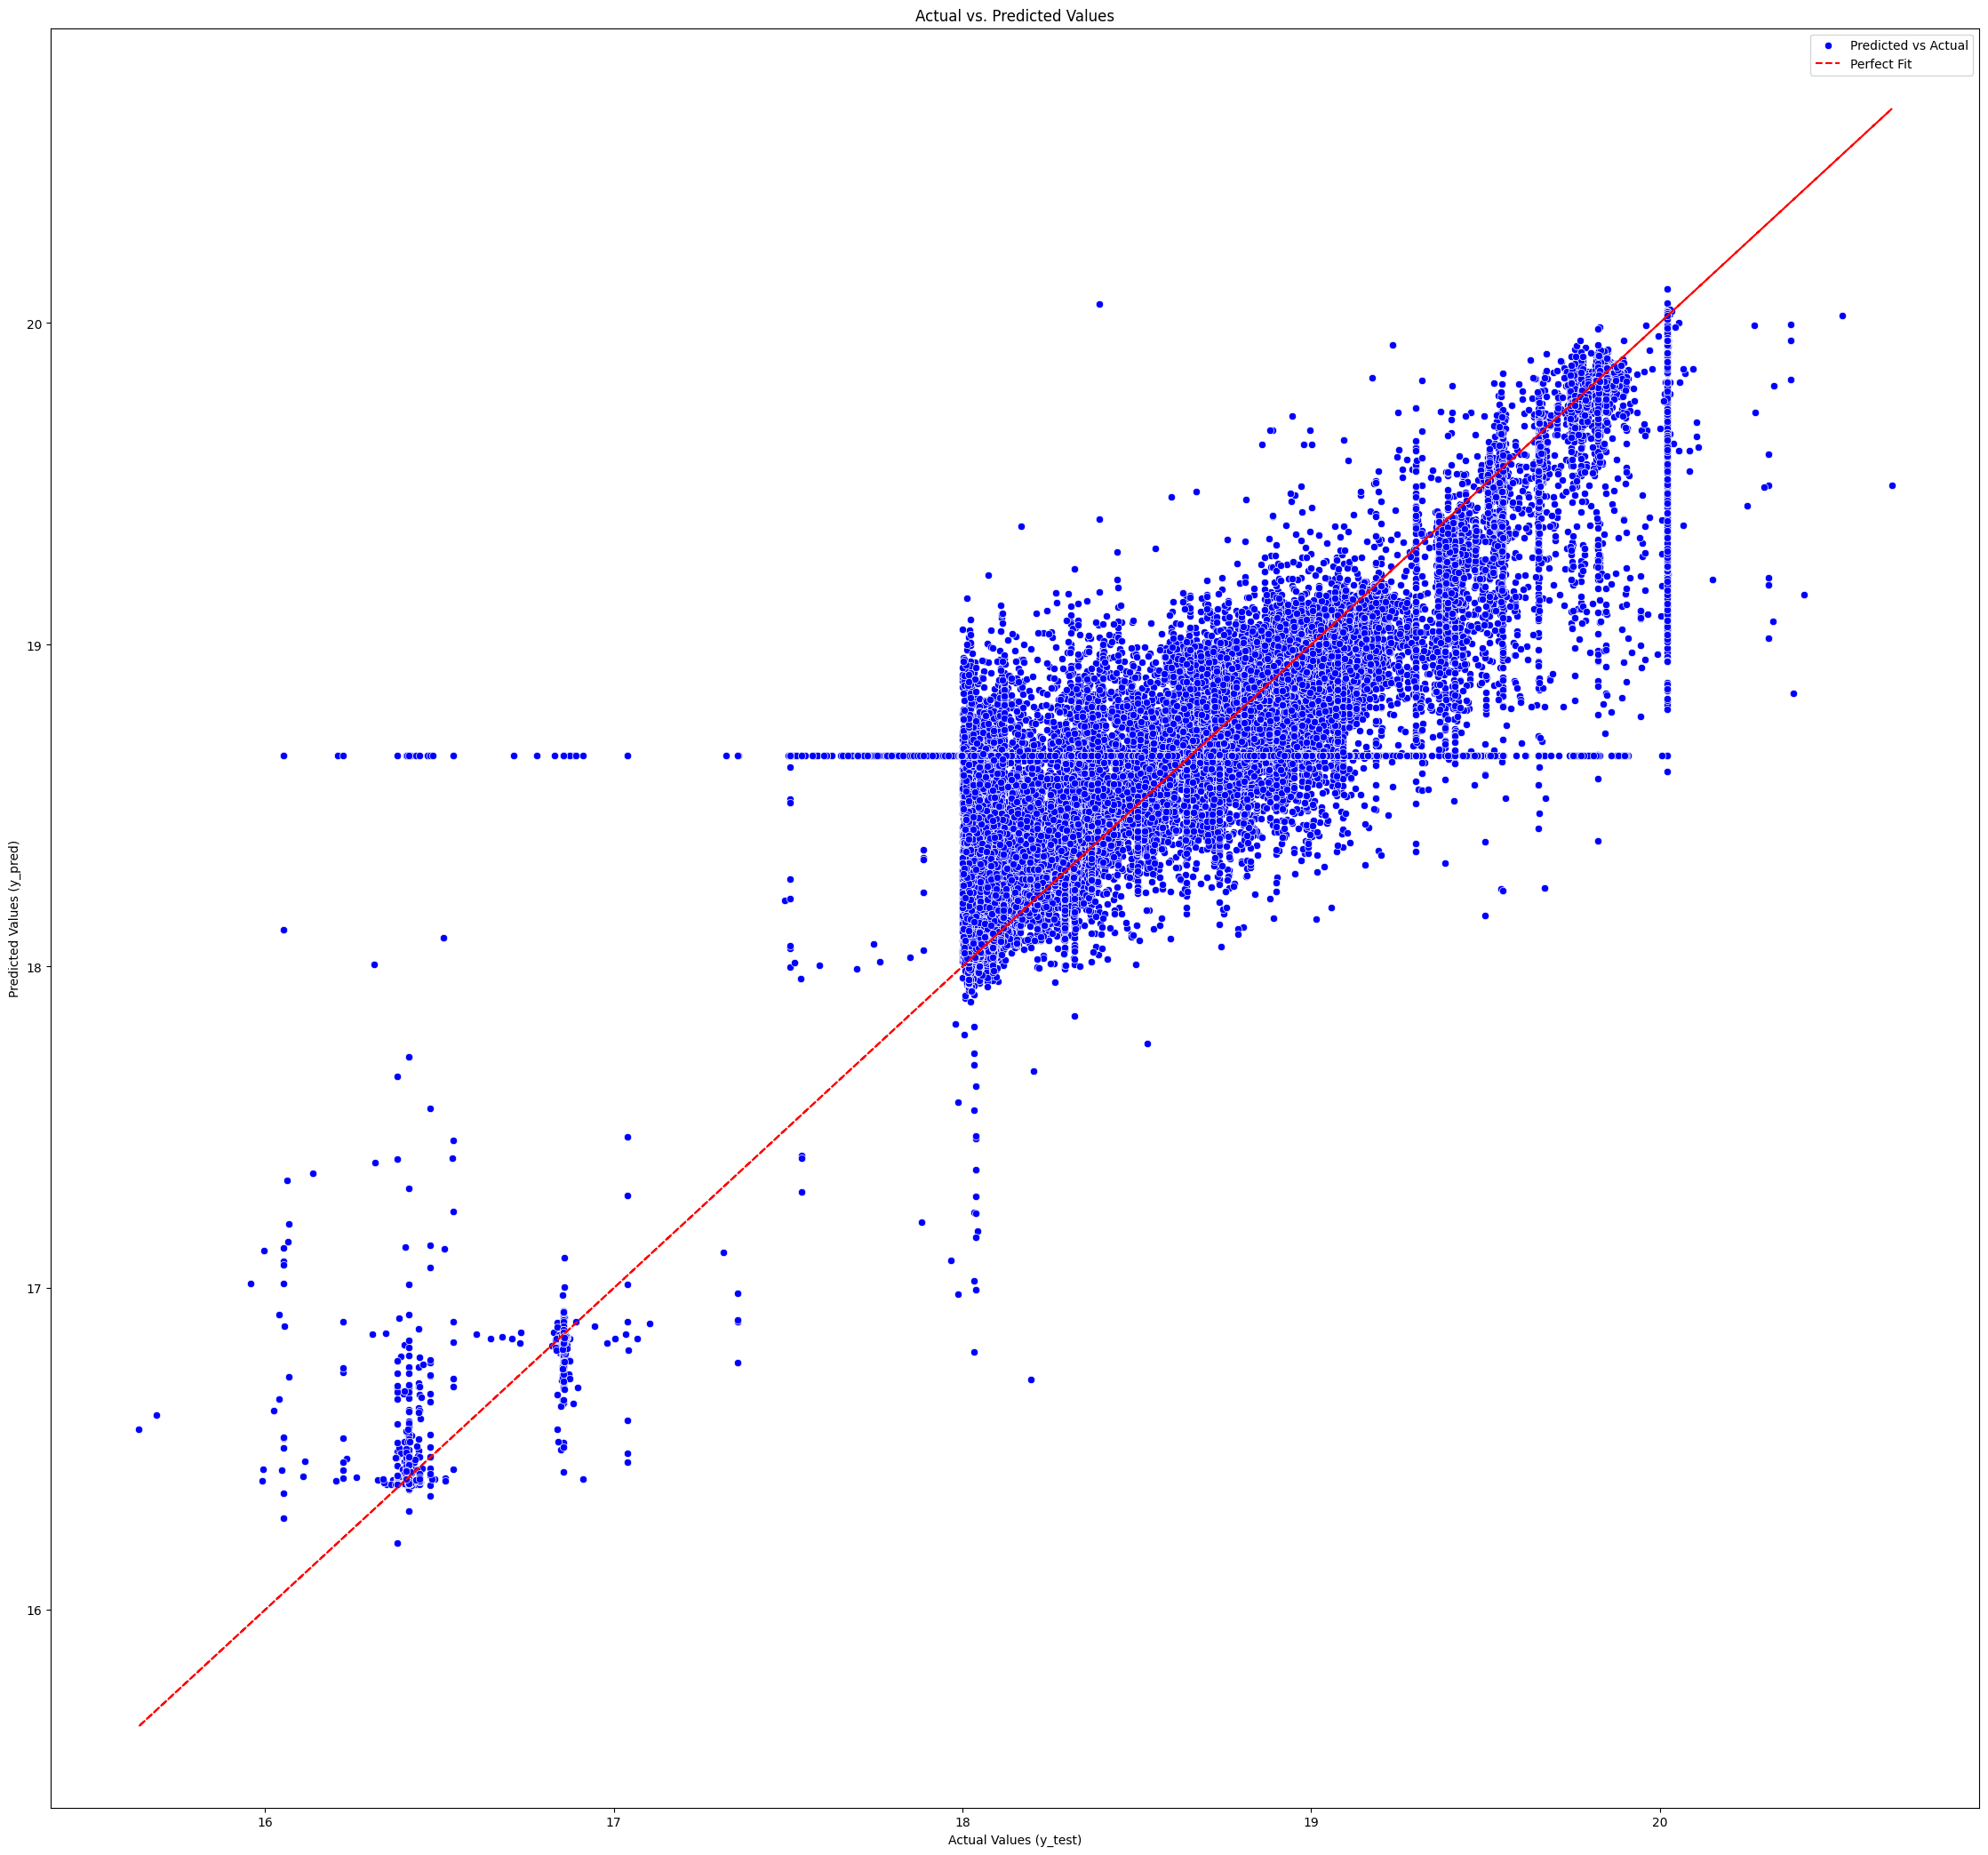

In [36]:
# Scatter plot
plt.figure(figsize=(28,26))
sns.scatterplot(x=y_test, y=y_pred, color='blue', label="Predicted vs Actual")
plt.plot(y_test, y_test, color='red', linestyle='dashed', label="Perfect Fit")  # Diagonal line

plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()